## Imports

In [1]:
from nb_utils import set_root

PROJECT_DIR = set_root(4)

In [2]:
import warnings
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, cohen_kappa_score, f1_score,
                             precision_score, recall_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from src.mlpr.ml.supervisioned.tunning.grid_search import GridSearch

warnings.filterwarnings("ignore")

%reload_ext autoreload

## Methods

In [3]:
def custom_accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return accuracy_score(y_true, y_pred, normalize=False)

## Parameters

In [4]:
n_samples = 1000
centers = [(0, 0), (3, 4.5)]
n_features = 2
cluster_std = 1.3
random_state = 42
cv = 10

In [5]:
np.random.seed(random_state)

In [6]:
params_split: dict[str, float | int] = {
    'test_size': 0.25,
    'random_state': random_state
}
params_norm: dict[str, bool] = {'with_mean': True, 'with_std': True}
model_metrics: dict[str, any] = {
    'custom_accuracy': custom_accuracy_score,
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'kappa': cohen_kappa_score,
    'f1': f1_score,
}

## Loading the Data

In [7]:
X, y = make_blobs(
    n_samples=n_samples,
    centers=centers,
    n_features=n_features,
    cluster_std=cluster_std,
    random_state=random_state
)

## Plot dataset

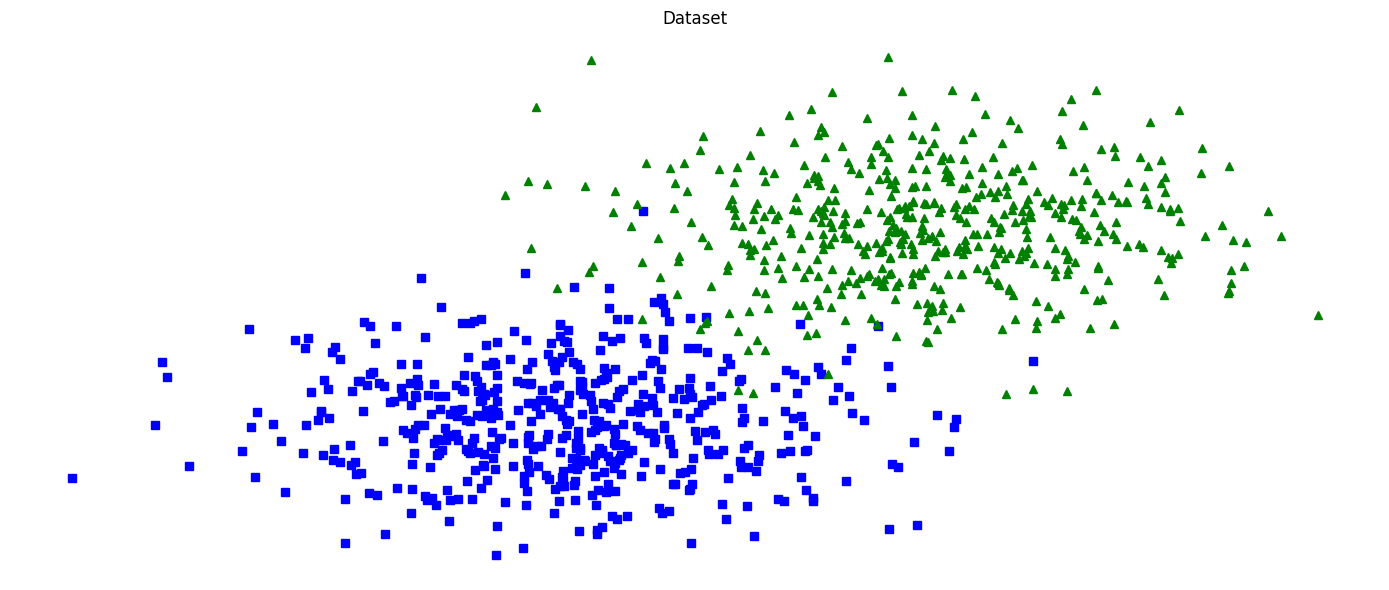

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
ax.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
ax.set_title("Dataset")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(PROJECT_DIR / "assets" / "tunning_scatter.png", dpi=400)
fig.tight_layout()

## Cross-validation

In [9]:
models: Dict[BaseEstimator, Dict] = {
    RandomForestClassifier: {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [random_state]
    },
    GradientBoostingClassifier: {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01, 0.005],
        'subsample': [0.5, 0.8, 1.0],
        'random_state': [random_state]
    },
    LogisticRegression: {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'random_state': [random_state]
    },
    GaussianNB: {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    KNeighborsClassifier: {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    SVC: {
        'C': [0.01, 0.1, 1.0, 10.0],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'random_state': [random_state]
    },
    DecisionTreeClassifier: {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [random_state]
    }
}

In [10]:
grid_search = GridSearch(
    X,
    y,
    params_split=params_split,
    models_params=models,
    normalize=True,
    params_norm=params_norm,
    scoring='accuracy',
    metrics=model_metrics
)
grid_search.search(cv=cv, n_jobs=-1)

best_model, best_params = \
    grid_search \
    .get_best_model()

100%|██████████| 7/7 [01:49<00:00, 15.68s/it]


In [11]:
results: pd.DataFrame = pd.DataFrame(grid_search._metrics).T
results

,custom_accuracy,accuracy,precision,recall,kappa,f1
RandomForestClassifier,244.0,0.976,0.975410,0.97541,0.951972,0.975410
GradientBoostingClassifier,245.0,0.980,0.983471,0.97541,0.959969,0.979424
LogisticRegression,245.0,0.980,0.983471,0.97541,0.959969,0.979424
GaussianNB,244.0,0.976,0.975410,0.97541,0.951972,0.975410
KNeighborsClassifier,245.0,0.980,0.983471,0.97541,0.959969,0.979424
SVC,245.0,0.980,0.983471,0.97541,0.959969,0.979424
DecisionTreeClassifier,245.0,0.980,0.983471,0.97541,0.959969,0.979424


## Predictions

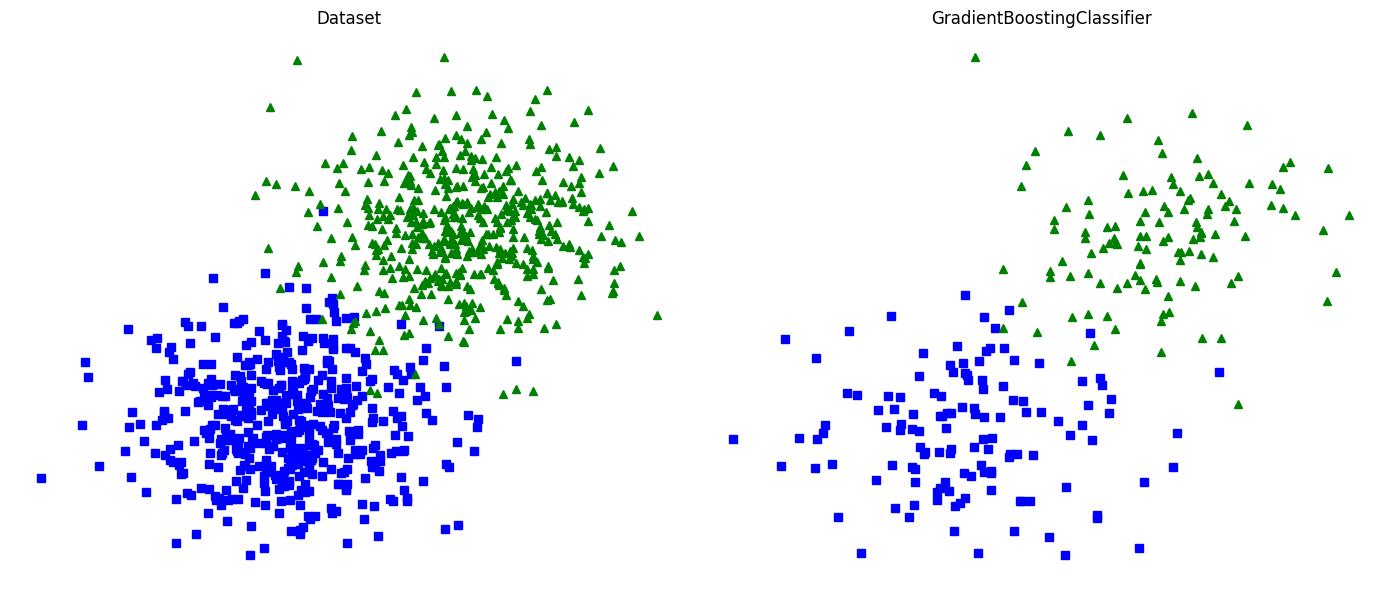

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
ax[0].plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
ax[0].set_title("Dataset")
ax[0].set_frame_on(False)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].plot(
    grid_search.X_test[:, 0][grid_search.y_test == 0],
    grid_search.X_test[:, 1][grid_search.y_test == 0],
    "bs"
)
ax[1].plot(
    grid_search.X_test[:, 0][grid_search.y_test == 1],
    grid_search.X_test[:, 1][grid_search.y_test == 1],
    "g^"
)
ax[1].set_title(grid_search.best_model.__class__.__name__)
ax[1].set_frame_on(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.savefig(PROJECT_DIR / "assets" / "tunning_best_model.png", dpi=400)
fig.tight_layout()